In [26]:
import tensorflow as tf
from keras import Sequential
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import numpy as np

Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


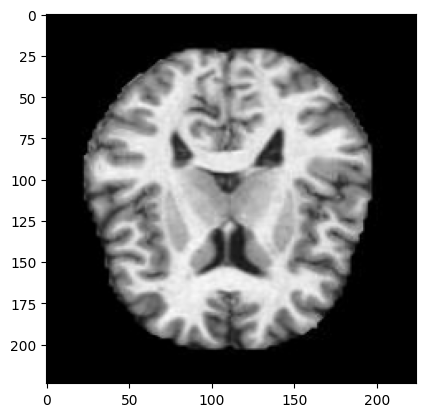

In [77]:
img_size = (224,224)

train_ds = keras.utils.image_dataset_from_directory(
    directory='Alzheimer_s Dataset/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=img_size)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='Alzheimer_s Dataset/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=img_size)

# batch_1=train_ds.take(1)
for images, labels in train_ds.take(1):
  for i in range(9):
    # ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    # plt.axis("off")




In [78]:
class_names = train_ds.class_names
print(class_names)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
0.0 0.96102756


In [80]:
num_classes = len(class_names)

model_MN = tf.keras.applications.MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model_MN.trainable = False

model = keras.Sequential([
  # layers.Rescaling(1./255, input_shape=(176, 208, 3)),
  # layers.Conv2D(16, (3,3),1, padding='same', activation='relu', input_shape=(176, 208, 3)),
  # layers.MaxPooling2D(),
  # layers.Conv2D(32, (3,3),1, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # layers.Conv2D(16, (3,3),1, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # layers.Flatten(),
  # layers.Dense(128, activation='relu'),
    model_MN,
  layers.Dense(num_classes)
])

model.build(img_size)


In [81]:
model.compile(optimizer='adam',loss=tf.losses.BinaryCrossentropy(),
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [82]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1000)              4253864   
 onal)                                                           
                                                                 
 dense_25 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 4257868 (16.24 MB)
Trainable params: 4004 (15.64 KB)
Non-trainable params: 4253864 (16.23 MB)
_________________________________________________________________


In [83]:
epochs=2
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)



Epoch 1/2
161/161 [==============================] - 222s 1s/step - loss: 0.8143 - accuracy: 0.1400 - val_loss: 0.6607 - val_accuracy: 0.1400
Epoch 2/2
161/161 [==============================] - 244s 2s/step - loss: 0.5963 - accuracy: 0.2529 - val_loss: 0.5770 - val_accuracy: 0.4887
